In [2]:
class CONFIG:
    external_data = False

In [3]:
# download the datasets

import os
import opendatasets as od
import pandas as pd
import json

data_path = "./pii-detection-removal-from-educational-data/"

# download the data from kaggle
if not os.path.exists(data_path):
    print("Dataset not found, downloading from Kaggle")
    dataset = "https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/data"
    od.download(dataset)
else:
    print("Dataset found in disk")

# check for the files present there
assert os.path.exists(data_path + "train.json"), "train.json file missing"
assert os.path.exists(data_path + "test.json"), "test.json file missing"


train_df = pd.read_json(open(data_path + "train.json"))
print("train_df loaded")

test_df = pd.read_json(open(data_path + "test.json"))
print("test_df loaded")

Dataset found in disk
train_df loaded
test_df loaded


In [4]:
# include external data

if CONFIG.external_data:
    # code to process external data
    pass

In [5]:
# scoring
from sklearn.metrics import fbeta_score

def fbeta_score(pred_df: pd.DataFrame, orig_df: pd.DataFrame, beta=5) -> float:
    '''
    PARAMS:
        pred_df - Dataframe consisting of predicted PII labels
        orig_df - Dataframe consisting of original PII labels
        beta    - Hyperparameter controlling the tradeoff between precision and recall (default 5)

    RETURNS:
        score   - calculated fbeta score
    '''

    tmp_df = pred_df.merge(orig_df, how = "outer", on = ["document", "token"], suffixes=["_pred", "_orig"])
    
    # create a temp column
    tmp_df["_label"] = ""

    # find all the rows in 'orig_df' which doesn't have a label and assign it as False Positive
    tmp_df.loc[tmp_df.label_orig.isna(), "_label"] = "FP"

    # find all the rows in 'pred_df' which doesn;t have a label and assign it as False Negative
    tmp_df.loc[tmp_df.label_pred.isna(), "_label"] = "FN"

    # find all the mismatch labels from both the dataframes and assign it as a False Negative
    tmp_df.loc[(tmp_df.label_orig.notna()) & (tmp_df.label_pred.notna()) & (tmp_df.label_pred != tmp_df.label_orig), "_label"] = "FN"

    # find all the matched labels from both the dataframes and assign it as a False Negative
    tmp_df.loc[(tmp_df.label_orig.notna()) & (tmp_df.label_pred.notna()) & (tmp_df.label_pred == tmp_df.label_orig), "_label"] = "TP"

    FP = (tmp_df["_label"] == "FP").sum()
    FN = (tmp_df["_label"] == "DN").sum()
    TP = (tmp_df["_label"] == "TP").sum()

    score = (1 + (beta**2)) * TP / (((1 + (beta**2)) * TP) + ((beta**2)*FN) + FP)

    return score



# EDA

### what is the distribution of number of tokens based on documents?
- The data is right skewed. There are more documents with the number of tokens between 500 and 1000


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


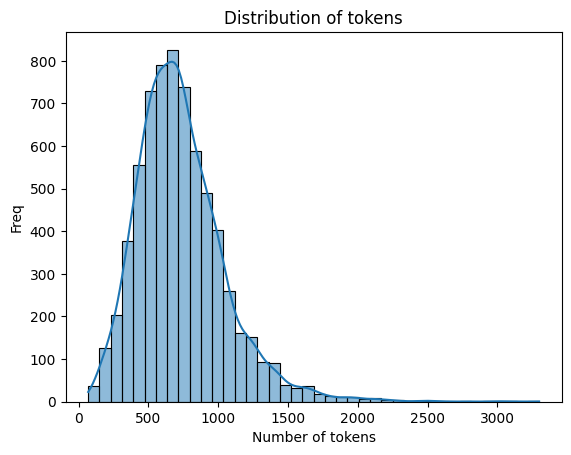

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

tmp_df = train_df.copy()

tmp_df["num_tokens"] = tmp_df["tokens"].apply(len)

sns.histplot(tmp_df["num_tokens"], bins = 40, kde=True)
plt.title("Distribution of tokens")
plt.xlabel("Number of tokens")
plt.ylabel("Freq")
plt.show()

### Total number of unique words in the data?
- there are 53,985 unique words in the training document

In [7]:
unique_words = tmp_df["tokens"].explode().unique().tolist()
print("Total unique words : ", len(unique_words))

Total unique words :  53985


### Unique types of labels ?
- "Email" and "USERNAME" doesn't have a "Inner flag. 
- so the tokenizer doesn't split up email and username
- A simple regex can be used to identify the email and username


In [8]:
unique_labels = tmp_df["labels"].explode().unique().tolist()
unique_labels = sorted(unique_labels, key=lambda x : x.split("-")[1] if x != "O" else "")
print("Unique Labels : \n")
print(unique_labels)

Unique Labels : 

['O', 'B-EMAIL', 'B-ID_NUM', 'I-ID_NUM', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-PHONE_NUM', 'I-PHONE_NUM', 'B-STREET_ADDRESS', 'I-STREET_ADDRESS', 'B-URL_PERSONAL', 'I-URL_PERSONAL', 'B-USERNAME']


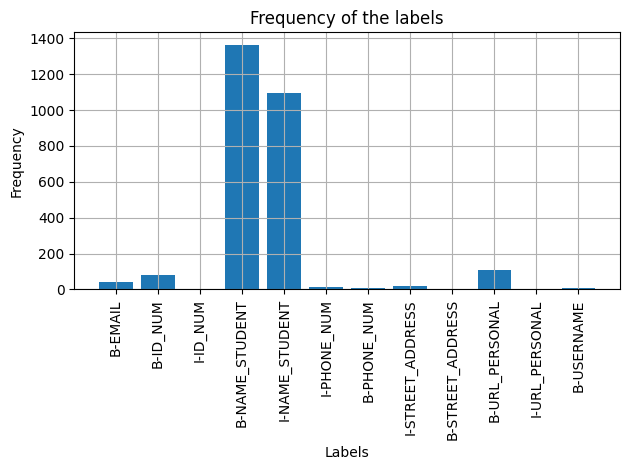

In [9]:
unique_labels = tmp_df["labels"].explode().value_counts().to_dict()
unique_labels = dict(sorted(unique_labels.items(), key=lambda x : x[0].split("-")[1] if x[0] != "O" else ""))
del unique_labels["O"]

plt.bar(unique_labels.keys(), unique_labels.values())

plt.title("Frequency of the labels")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.grid()

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### Example for Emails

In [10]:
import re

def is_email(text):
    # Regular expression pattern for matching email addresses
    pattern = r'^[\w\.-]+@[\w\.-]+\.\w+$'
    return re.match(pattern, text) is not None

email = "example@email.com"
non_email = "notanemail.com"

print(is_email(email))    
print(is_email(non_email)) 

True
False


### Example for Username
- There are only a total of 6 username in the whole dataset

In [11]:
usernames = tmp_df.explode(["labels", "tokens"]).reset_index()
usernames = usernames[usernames["labels"] == "B-USERNAME"]["tokens"].tolist()
usernames

['castanedagabriel',
 'fdixon',
 'fdixon',
 'meyermichelle',
 'jacob59',
 'holmespatrick']

### Example of ID_NUM

In [12]:
id_num = tmp_df.explode(["labels", "tokens"]).reset_index()
id_num_b = id_num[id_num["labels"] == "B-ID_NUM"]["tokens"].tolist()
id_num_i = id_num[id_num["labels"] == "I-ID_NUM"]["tokens"].tolist()

print(f"B-ID_NUM ({len(list(set(id_num_b)))} / {len(id_num_b)}) : ", id_num_b[:10])
print(f"I-ID_NUM ({len(list(set(id_num_i)))} / {len(id_num_i)}) : ", id_num_i[:10])

B-ID_NUM (67 / 78) :  ['860632713425', '530670102508', '530670102508', '875673967537', '860632713425', '557349702179', '784372734211', '054176622314', '674915248960', '932353568953']
I-ID_NUM (1 / 1) :  ['30407059']


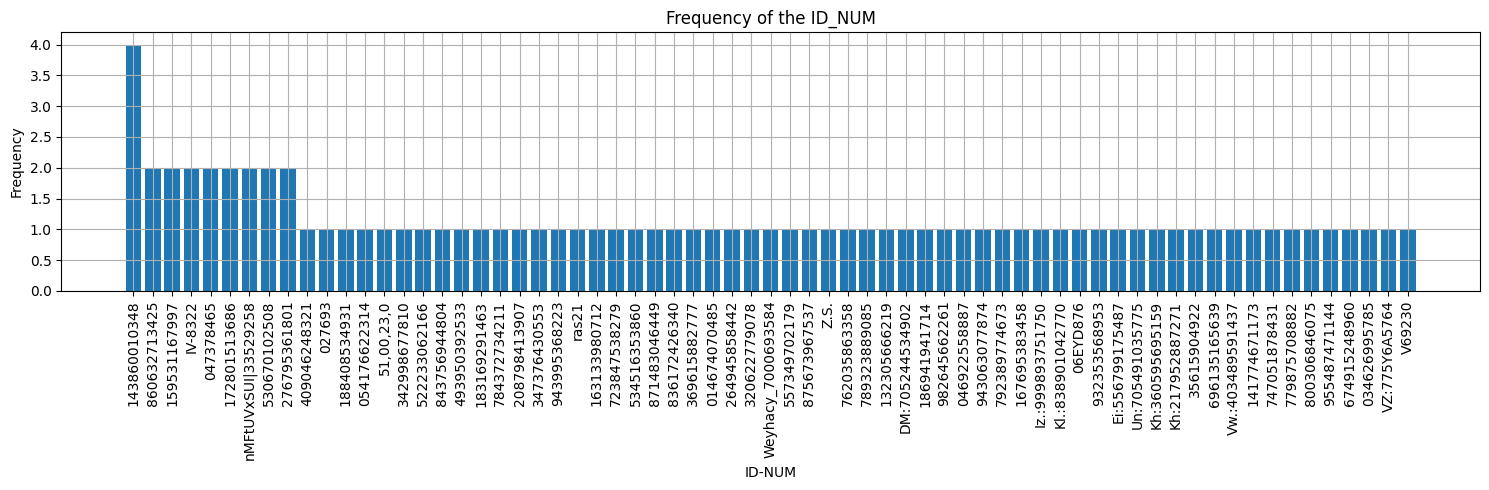

In [13]:
id_num_b = id_num[id_num["labels"] == "B-ID_NUM"]["tokens"].value_counts()
id_num_i = id_num[id_num["labels"] == "I-ID_NUM"]["tokens"].value_counts()

plt.figure(figsize=(15,5))
plt.bar(id_num_b.index, id_num_b)

plt.title("Frequency of the ID_NUM")
plt.xlabel("ID-NUM")
plt.ylabel("Frequency")
plt.grid()

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### Example for NAME-STUDENT

In [14]:
name_stud = tmp_df.explode(["labels", "tokens"]).reset_index()
name_stud_b = name_stud[name_stud["labels"] == "B-NAME_STUDENT"]["tokens"].tolist()
name_stud_i = name_stud[name_stud["labels"] == "I-NAME_STUDENT"]["tokens"].tolist()

print(f"B-NAME_STUDENT ({len(list(set(name_stud_b)))} / {len(name_stud_b)}) : ", name_stud_b[:10])
print(f"I-NAME_STUDENT ({len(list(set(name_stud_i)))} / {len(name_stud_i)}) : ", name_stud_i[:10])

B-NAME_STUDENT (685 / 1365) :  ['Nathalie', 'Nathalie', 'Nathalie', 'Diego', 'Diego', 'Gilberto', 'Sindy', 'Nadine', 'Eladio', 'Silvia']
I-NAME_STUDENT (643 / 1096) :  ['Sylla', 'Sylla', 'Sylla', 'Estrada', 'Estrada', 'Gamboa', 'Samaca', 'Born', 'Amaya', 'Villalobos']


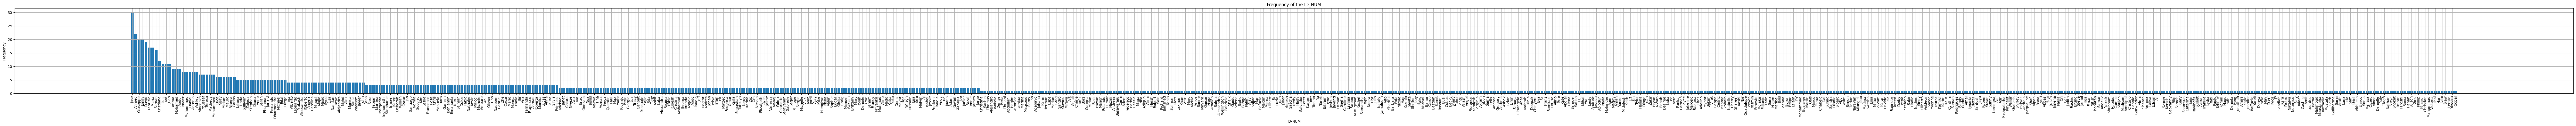

In [15]:
name_stud_b = name_stud[name_stud["labels"] == "B-NAME_STUDENT"]["tokens"].value_counts()
name_stud_i = name_stud[name_stud["labels"] == "I-NAME_STUDENT"]["tokens"].value_counts()

plt.figure(figsize=(100,5))
plt.bar(name_stud_b.index, name_stud_b)

plt.title("Frequency of the ID_NUM")
plt.xlabel("ID-NUM")
plt.ylabel("Frequency")
plt.grid()

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### Example PHONE_NUM
- The phone number of not tht accurate

In [16]:
phone_num = tmp_df.explode(["labels", "tokens"]).reset_index()
phone_num_b = phone_num[phone_num["labels"] == "B-PHONE_NUM"]["tokens"].tolist()
phone_num_i = phone_num[phone_num["labels"] == "I-PHONE_NUM"]["tokens"].tolist()

print(f"B-PHONE_NUM ({len(list(set(phone_num_b)))} / {len(phone_num_b)}) : ", phone_num_b[:10])
print(f"I-PHONE_NUM ({len(list(set(phone_num_i)))} / {len(phone_num_i)}) : ", phone_num_i[:10])

B-PHONE_NUM (2 / 6) :  ['(', '(', '(', '(', '(', '410.526.1667']
I-PHONE_NUM (7 / 15) :  ['320)202', '-', '0688x95843', '223)392', '-', '2765', '820)913', '-', '3241x894', '820)913']


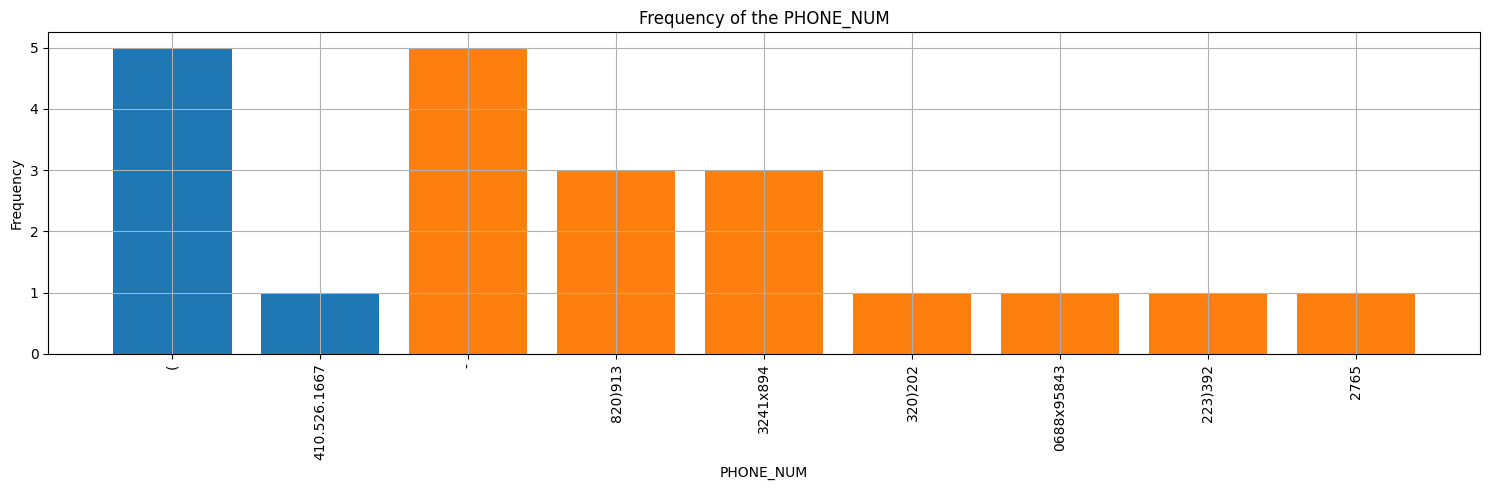

In [17]:
phone_num_b = phone_num[phone_num["labels"] == "B-PHONE_NUM"]["tokens"].value_counts()
phone_num_i = phone_num[phone_num["labels"] == "I-PHONE_NUM"]["tokens"].value_counts()

plt.figure(figsize=(15,5))
plt.bar(phone_num_b.index, phone_num_b)
plt.bar(phone_num_i.index, phone_num_i)

plt.title("Frequency of the PHONE_NUM")
plt.xlabel("PHONE_NUM")
plt.ylabel("Frequency")
plt.grid()

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

##### Does phone numbers have white spaces between tokens

In [42]:
phone_num = tmp_df.explode(["labels", "tokens", "trailing_whitespace"]).reset_index()

phone_num_b = phone_num[phone_num["labels"] == "B-PHONE_NUM"]["trailing_whitespace"].value_counts()
phone_num_i = phone_num[phone_num["labels"] == "I-PHONE_NUM"]["trailing_whitespace"].value_counts()

display(phone_num_b)
display(phone_num_i)

trailing_whitespace
False    5
True     1
Name: count, dtype: int64

trailing_whitespace
False    14
True      1
Name: count, dtype: int64

In [54]:
def find_phone_numbers(text):
    # Define the regular expression pattern to match phone numbers
    pattern = r'\(?(\d{3})\)?[. ]?(\d{3})[. ]?(\d{4})\b'

    # Find all matches of the pattern in the text
    matches = re.findall(pattern, text)
    print(matches)
    # Process matches to format them properly
    phone_numbers = []
    for match in matches:
        formatted_number = ''.join(match)
        phone_numbers.append(formatted_number)

    return phone_numbers

# Example usage:
text = """
Here are some phone numbers:
(123) 456 7890,
(987)6543210,
999.999.9999,
1234x12345,
1234567890
"""
numbers = find_phone_numbers(text)
print("Phone numbers found:", numbers)

[('123', '456', '7890'), ('987', '654', '3210'), ('999', '999', '9999'), ('123', '456', '7890')]
Phone numbers found: ['1234567890', '9876543210', '9999999999', '1234567890']


### Example STREET_ADDRESS

In [18]:
street_add = tmp_df.explode(["labels", "tokens"]).reset_index()
street_add_b = street_add[street_add["labels"] == "B-STREET_ADDRESS"]["tokens"].tolist()
street_add_i = street_add[street_add["labels"] == "I-STREET_ADDRESS"]["tokens"].tolist()

print(f"B-STREET_ADDRESS ({len(list(set(street_add_b)))} / {len(street_add_b)}) : ", street_add_b[:10])
print(f"I-STREET_ADDRESS ({len(list(set(street_add_i)))} / {len(street_add_i)}) : ", street_add_i[:10])

B-STREET_ADDRESS (2 / 2) :  ['591', '743']
I-STREET_ADDRESS (16 / 20) :  ['Smith', 'Centers', 'Apt', '.', '656', '\n', 'Joshuamouth', ',', 'RI', '95963']


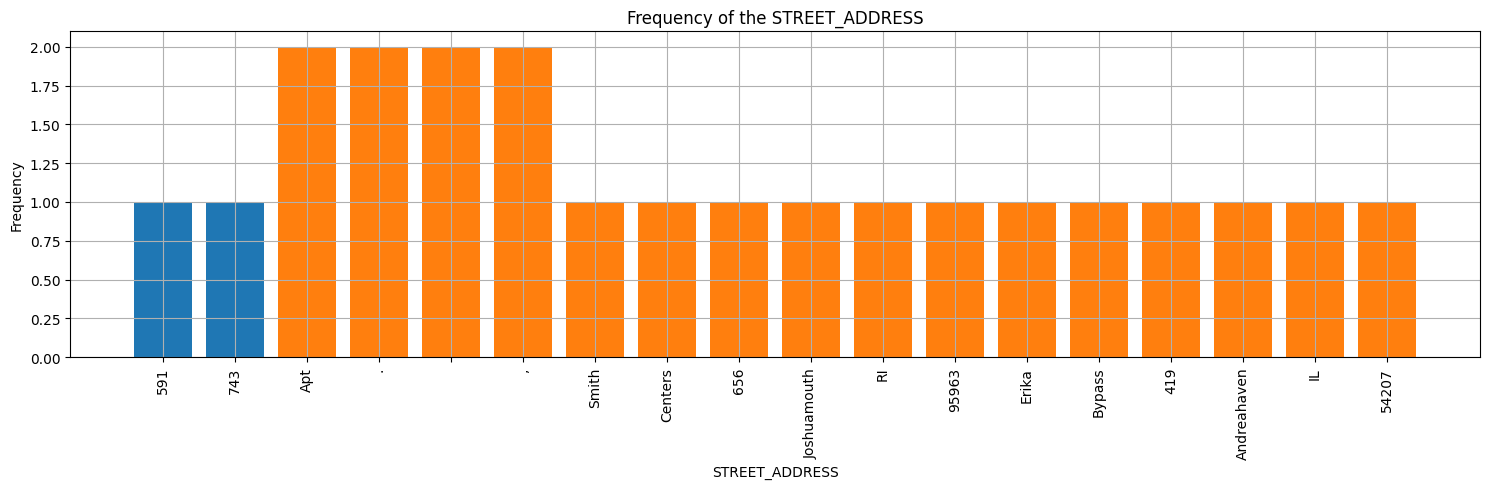

In [19]:
street_add_b = street_add[street_add["labels"] == "B-STREET_ADDRESS"]["tokens"].value_counts()
street_add_i = street_add[street_add["labels"] == "I-STREET_ADDRESS"]["tokens"].value_counts()

plt.figure(figsize=(15,5))
plt.bar(street_add_b.index, street_add_b)
plt.bar(street_add_i.index, street_add_i)

plt.title("Frequency of the STREET_ADDRESS")
plt.xlabel("STREET_ADDRESS")
plt.ylabel("Frequency")
plt.grid()

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

#### Name Student

In [ ]:
``

### Example : URL_PERSONAL
- we can use regex to solve this

In [20]:
url_pers = tmp_df.explode(["labels", "tokens"]).reset_index()
url_pers_b = url_pers[url_pers["labels"] == "B-URL_PERSONAL"]["tokens"].tolist()
url_pers_i = url_pers[url_pers["labels"] == "I-URL_PERSONAL"]["tokens"].tolist()

print(f"B-STREET_ADDRESS ({len(list(set(url_pers_b)))} / {len(url_pers_b)}) : ", url_pers_b[:10])
print(f"I-STREET_ADDRESS ({len(list(set(url_pers_i)))} / {len(url_pers_i)}) : ", url_pers_i[:10])

B-STREET_ADDRESS (95 / 110) :  ['https://www.jackson.com/list/explorehomepage.htm', 'https://www.linkedin.com/in/mmartinez', 'https://youtu.be/rFD2lJuvace', 'https://www.hall.biz/wp-contenthome.html', 'http://www.burns-lopez.com/categories/appabout.asp', 'http://jacobs-fisher.com/listpost.html', 'https://www.youtube.com/watch?v=n-ajTPJ1h-J', 'tps://www.facebook.com/bclark', 'https://www.youtube.com/channel/UC1ElAcppeuhfet', 'https://oconnell-townsend.com/wp-content/categorieshomepage.html']
I-STREET_ADDRESS (1 / 1) :  ['nYZqnhEXw']


/var/folders/bl/78xnml8j3qj74t4c1j3s2jhw0000gn/T/ipykernel_8657/3485205104.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


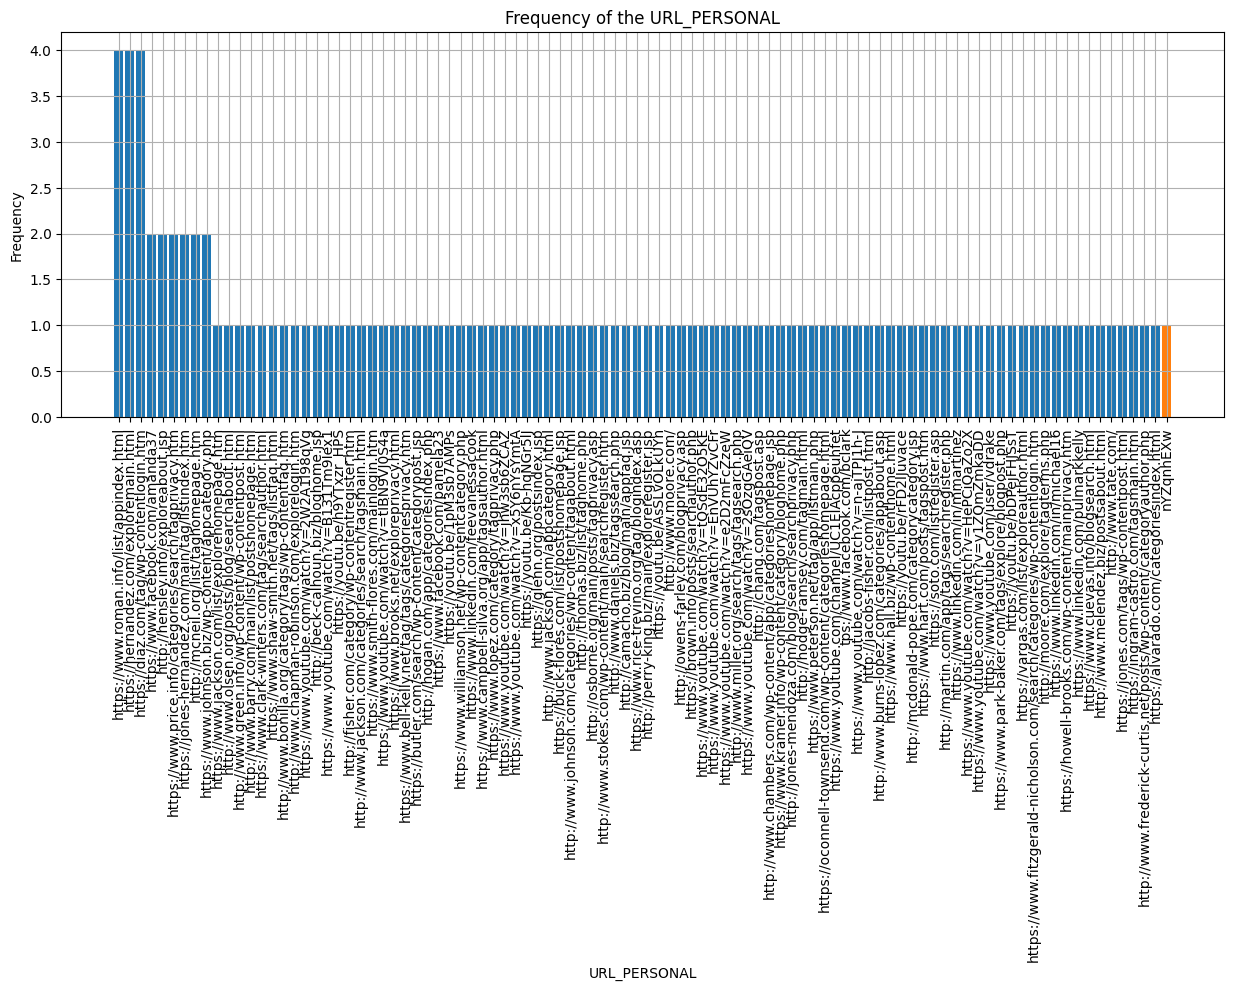

In [51]:
url_pers_b = url_pers[url_pers["labels"] == "B-URL_PERSONAL"]["tokens"].value_counts()
url_pers_i = url_pers[url_pers["labels"] == "I-URL_PERSONAL"]["tokens"].value_counts()

plt.figure(figsize=(15,5))
plt.bar(url_pers_b.index, url_pers_b)
plt.bar(url_pers_i.index, url_pers_i)

plt.title("Frequency of the URL_PERSONAL")
plt.xlabel("URL_PERSONAL")
plt.ylabel("Frequency")
plt.grid()

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

#### Get url function

In [22]:
def get_url(text):
    url_pattern = r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+'
    urls = re.findall(url_pattern, text)
    return urls

urls = " ".join(url_pers_b.index.to_list())
print(get_url(urls))

['https://www.roman.info', 'https://hernandez.com', 'https://diaz.com', 'https://www.facebook.com', 'http://hensley.info', 'https://www.price.info', 'https://jones-hernandez.com', 'http://mcneil.org', 'https://www.johnson.biz', 'https://www.jackson.com', 'http://www.olsen.org', 'http://www.green.info', 'http://www.barry.com', 'https://www.clark-winters.com', 'https://www.shaw-smith.net', 'http://www.bonilla.org', 'http://www.chapman-robinson.com', 'https://www.youtube.com', 'http://beck-calhoun.biz', 'https://www.youtube.com', 'https://youtu.be', 'http://fisher.com', 'http://www.jackson.com', 'https://www.smith-flores.com', 'https://www.youtube.com', 'https://www.brooks.net', 'https://www.bell-kelly.net', 'https://butler.com', 'http://hogan.com', 'https://www.facebook.com', 'https://youtu.be', 'https://www.williamson.net', 'https://www.linkedin.com', 'https://www.campbell-silva.org', 'https://www.lopez.com', 'https://www.youtube.com', 'https://www.youtube.com', 'https://youtu.be', 'htt

#### Figure out which label has connecting elements
- Email and username are singe tokens
- All other categories are multiple tokens


In [30]:
unique_labels = tmp_df["labels"].explode().value_counts().to_dict()
unique_labels = dict(sorted(unique_labels.items(), key=lambda x : x[0].split("-")[1] if x[0] != "O" else ""))

label_cat = {}
del unique_labels["O"]


for k in unique_labels:
    cat = k.split("-")[1]
    cont = k.split("-")[0]
    if cat not in label_cat:
        label_cat[cat] = []
    label_cat[cat].append(cont)

print(label_cat)


{'EMAIL': ['B'], 'ID_NUM': ['B', 'I'], 'NAME_STUDENT': ['B', 'I'], 'PHONE_NUM': ['I', 'B'], 'STREET_ADDRESS': ['I', 'B'], 'URL_PERSONAL': ['B', 'I'], 'USERNAME': ['B']}


# Brute force

### Email:
- Since they are single tokens, we can just use a regex match to obtain them

### Username:
- We can use brute force solution of maintaining all the username examples from the training data and then trying to figure out whether it matches

### Phone Num:
- We can use regex matching by combining the tokens

### URL Patterns:
- The I continuity happens very low. So we can use a brute force approach and disregard them. Use a regex to find the urls

### NAME STUDENT
- 


In [37]:
t = test_df.copy()
t.head()


,document,full_text,tokens,trailing_whitespace
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal..."
